# 自己組織化マップ（SOM)＆クラスタリング

自己組織化マップのわかり易い例として、入力をRGB３原色の組とし、色データを２次元空間にマッピングするという例がある。

個々のカラーデータは３つの成分を持つので３次元空間に分布するデータなわけだが、それを２次元に配置するということは１次元分次元を圧縮することになる。

たとえば、[勝手に整理整頓 ─ 自動分類アルゴリズム](http://gaya.jp/spiking_neuron/som.htm) がすごくわかりやすい。

この例を取り上げているサイトはたくさんあって、たいていはひたすらランダムに３原色を発生させてマップを更新するというプログラムになっている。

次元圧縮という意味では、最終的にあらゆる色をマッピングしないといけないのだから、それでいいわけなのだけど、通常自己組織化マップをつくる時はランダムにあらゆるデータを生成するのではなく、実際に観測された多次元データを２次元にマッピングしてああだこうだと解析するのに使うわけで、無限に（実際にはデジタルの色は有限だが）色を発生させて組織化するというのはなんか違う、という気がする。

そこで、このプログラムではランダムに色を発生させるのではなく、実際の画像に使われている色をランダムにピックアップして使うという風にしてみた。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
% matplotlib notebook
# % matplotlib inline
import urllib.request
import io
import PIL.Image
import cv2

# ネット上の画像を取ってくるメソッド
def url2img(url):
    print(url)
    f = io.BytesIO(urllib.request.urlopen(url).read())
    img = PIL.Image.open(f)
    imgArray = np.asarray(img)
    return imgArray

# 画像から　色を　num 個ピックアップするメソッド
def pickcolor(imgArray, num):
    w = imgArray.shape[1]
    h = imgArray.shape[0]
    ret = []
    for i in range(num):
        rw = int(w*np.random.rand())
        rh = int(h*np.random.rand())
        ret.append(imgArray[rh,rw]/255)
    return ret

In [2]:
import scipy.stats as st
# ガウス分布
def gkern(kernlen=21, nsig=3):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

# 自己組織化マップ SOM を生成する　　　　M :２次元配置されたニューロンの重み配列    x : 入力データ,  alpha：学習係数
def organize_som(M, x, alpha=0.3, ksize=3):
    gk = gkern(2*ksize+1,ksize)/np.max(gkern(2*ksize+1,ksize))
    mini, minj = get_winner(M,x)
    MM = np.zeros((M.shape[0]+2*ksize, M.shape[1]+2*ksize,3),np.float64)
    MM[ksize:-ksize,ksize:-ksize]=M
    for i in range(-ksize,ksize+1): #  勝者の近傍7x7 の範囲を与えられたデータ（このプログラムでは色）に近づける
        for j in range(-ksize,ksize+1):
            try:
                MM[ksize+mini+i,ksize+minj+j] += alpha * (x - MM[ksize+mini+i,ksize+minj+j])*gk[ksize+i,ksize+j]
            except:
                pass
    return MM[ksize:-ksize,ksize:-ksize]

def show_som(M):
    im = plt.imshow(M,interpolation='nearest',origin='lower')
    return im

# Map M において、ベクトルｘともっとも近い重みベクトルを持つノードの座標を得る
def get_winner(M,x):
    col =  M.shape[1]
    # row =  M.shape[0]
    min_i = np.argmin(((M-x)**2).sum(axis=2)) 
    mini = min_i // col # argmin は1次元化した番号が返ってくるので　2次元化
    minj = min_i % col
    return mini, minj

# 配列３次元M（ただし最後の次元は３要素でありカラーデータとみなせるもの）を matplot 画像データとして返す
def show_som(M):
    im = plt.imshow(M,interpolation='none',origin='lower')
    return im

ウェブ上の画像をカラーデータの採取用に読み込む

http://photoshopvip.net/wp-content/uploads/2016/12/intro-to-natural-palette-1.jpg


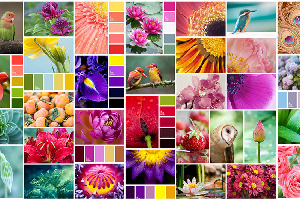

In [3]:
imgArray = url2img("http://photoshopvip.net/wp-content/uploads/2016/12/intro-to-natural-palette-1.jpg")
PIL.Image.fromarray(imgArray).resize((300,200))

<IPython.core.display.Javascript object>


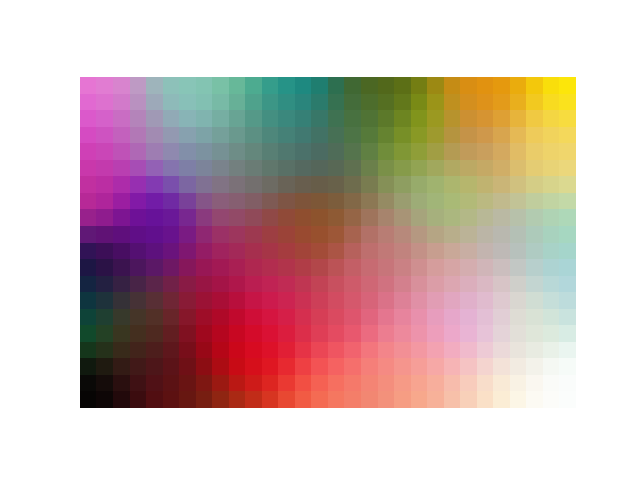

In [4]:
# メインプログラム
row = 20  # 高さ
col = 30 # 幅
learntime = 256 # 繰り返し学習回数
batchsize = 128 # １回の繰り返しで採取するデータの数
alpha = 0.3 # 学習係数

W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
            #W=organize_som(W, color) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

このマップは20ｘ30個のRGBのデータ集合だと考えられる。この600個のデータをK-Means法でクラスタリングしてみよう。

いま、Wは20ｘ30の行列表現されているが、これを　600個のデータ列に変換しないといけない。

In [5]:
from sklearn.cluster import KMeans

def kmeans(M,k,itr):   # 配列Mの要素を対象として k-Means 法でクラスタリングを実行する　　k クラスタ数、 itr 繰り返し処理回数
    row = M.shape[0]
    col = M.shape[1]
    ch = M.shape[2]
    data = M.reshape(col*row,ch)
    km = KMeans(n_clusters=k,init='random',n_init=1,max_iter=itr,random_state=1)
    labelimage = (km.fit(data).labels_).reshape(row,col)
    centers = km.cluster_centers_
    return labelimage, centers 

from matplotlib.colors import LinearSegmentedColormap
# カスタムカラーマップの生成
def generate_cmap(centers):
    lebels = len(centers)
    values = range(lebels)
    color_list = centers # ３次元データの重心の値そのものをカラーデータとみなす
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

In [6]:
# 境界の描画
def plotBoundary(labels, somcenters, cmap='tab20', colorbar=True):
    row = labels.shape[0]
    col = labels.shape[1]
    
    YY,XX = np.mgrid[0:row, 0:col] # make a grid    
    
    plt.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10) 
    
    if colorbar:
        plt.colorbar()
        
    for index, p in enumerate(somcenters):
        plt.text(p[1],p[0],str(index),ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.3, lw=0))

[(8, 12), (3, 3), (16, 25), (11, 6), (6, 19), (6, 26), (14, 16), (16, 7)]


<IPython.core.display.Javascript object>


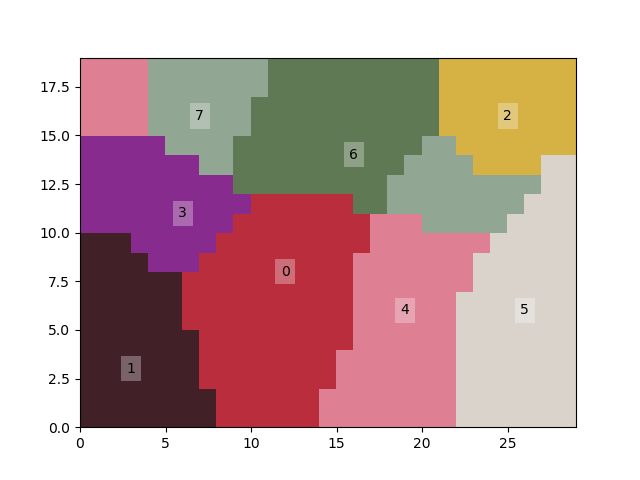

In [7]:
# 代表色8
labelimage, centers = kmeans(W,8,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap, colorbar=False)

[(14, 27), (14, 16), (18, 26), (14, 3), (17, 2), (3, 26), (11, 20), (16, 10), (10, 11), (4, 12), (9, 5), (19, 4), (3, 3), (16, 21), (6, 21), (6, 17)]


<IPython.core.display.Javascript object>


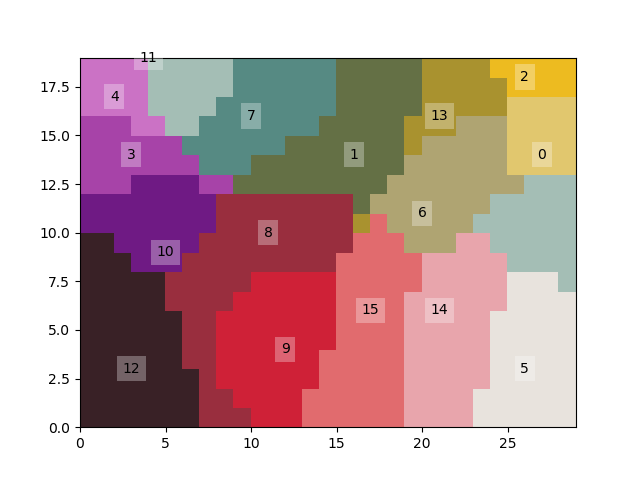

In [8]:
# 代表色16色
labelimage, centers =  kmeans(W,16,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap, colorbar=False)

# 固定１５色

PyMVPAというライブラリの公式ページにある　　SOM のサンプル[Self-organizing Maps](http://www.pymvpa.org/examples/som.html)と同じことを試してみる。

このサンプルもやはり色データをSOMにマッピングする例であるが、色が固定されている。たまたまだが、マップのサイズは２０ｘ３０で、ここで最初に試した設定と同じ。

In [9]:
dcolors = np.array(
         [[0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.5],
          [0.125, 0.529, 1.0],
          [0.33, 0.4, 0.67],
          [0.6, 0.5, 1.0],
          [0., 1., 0.],
          [1., 0., 0.],
          [0., 1., 1.],
          [1., 0., 1.],
          [1., 1., 0.],
          [1., 1., 1.],
          [.33, .33, .33],
          [.5, .5, .5],
          [.66, .66, .66]])

dcolors = dcolors*0.9+0.05

dcolor_names = \
        ['black', 'blue', 'darkblue', 'skyblue',
         'greyblue', 'lilac', 'green', 'red',
         'cyan', 'violet', 'yellow', 'white',
         'darkgrey', 'mediumgrey', 'lightgrey']

サンプリングされるデータが固定の場合、最もそのデータに似ているノードがさらにそのデータに似るように重みを変化させているのであるから、繰り返しているうちに第２候補と立場が逆転するということはまず起こり得ない。たまたま似たデータに引きづられて変化した結果としてそういうことが起こり得ないとは言えないが、空間がスパース（空き空き）であると、まずそういうことは起こらない。

そこで、与えられた固定データを中心に乱数で少しゆらぎを与えることにする。

<IPython.core.display.Javascript object>


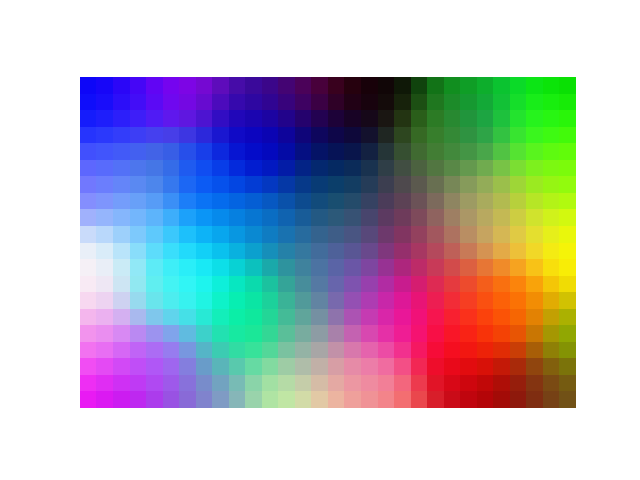

In [10]:
# メインプログラム
row = 20  # 高さ
col = 30 # 幅
learntime = 500 # 繰り返し学習回数
alpha = 0.3 # 学習係数

W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

def vcolor(color,sigma):
    vc = [ np.clip(c+np.random.normal(0,sigma),0,1)  for  c in color]
    return vc

for time in range(learntime):
    for color in dcolors:
            W=organize_som(W, vcolor(color,0.25),alpha=alpha,ksize=4) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
ani.save("som3.mp4")  # ffmpeg がインストールされていないと動かない
plt.show()

<IPython.core.display.Javascript object>


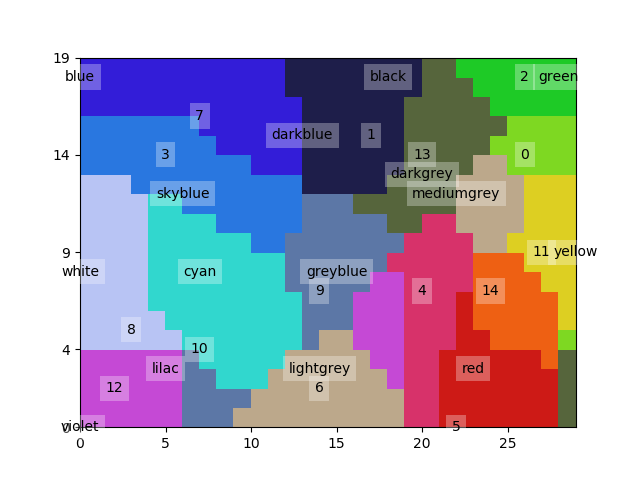

[(14, 26), (15, 17), (18, 26), (14, 5), (7, 20), (0, 22), (2, 14), (16, 7), (5, 3), (7, 14), (4, 7), (9, 27), (2, 2), (14, 20), (7, 24)]
[(18, 18), (18, 0), (15, 13), (12, 6), (8, 15), (3, 5), (18, 28), (3, 23), (8, 7), (0, 0), (9, 29), (8, 0), (13, 20), (12, 22), (3, 14)]


In [13]:
# ラベル貼り付け
labelimage,centers = kmeans(W,15,100)
somcenters = [get_winner(W,c)  for c in centers]
custom_cmap = generate_cmap(centers)
plt.yticks( [0, 4,9,14, 19] )
plotBoundary(labelimage, somcenters, cmap=custom_cmap, colorbar=False)

colorlocations = [get_winner(W,c)  for c in dcolors]
print(somcenters)
print(colorlocations)
for index, p in enumerate(colorlocations):
    plt.text(p[1],p[0],dcolor_names[index],ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.3, lw=0))

参考

- [SOM（自己組織化写像）のプログラム (python)](http://swdrsker.hatenablog.com/entry/2016/12/08/171356) を小サイズ化したプログラム
- [ffmpeg DOWNLOAD](http://www.ffmpegmac.net/)